# Llama 2: 

An updated auto-regressive transformer

In [33]:
import torch, transformers
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass, field
from typing import List, Tuple, Dict, Optional, Union
from transformers import AutoTokenizer

## Running Inference:


For this model you need hugging face pro, request access from meta, and set up an access token to log in via the command line (I believe there are other ways to authenticate). 

In [34]:
model = "meta-llama/Llama-2-7b-chat-hf"

In [35]:
tokenizer = AutoTokenizer.from_pretrained(model)
pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    torch_dtype=torch.float16,
    device_map="auto",
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [36]:

sequences = pipeline(
    'I liked "Full Swing" and "Drive to Survive". Do you have any recommendations of other shows I might like?\n',
    do_sample=True,
    top_k=10,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
    max_length=500,
    truncation=True
)
for seq in sequences:
    print(f"Result: \n {seq['generated_text']}")

Result: 
 I liked "Full Swing" and "Drive to Survive". Do you have any recommendations of other shows I might like?

Answer: Yes, definitely! If you enjoyed "Full Swing" and "Drive to Survive," here are some other shows you might enjoy:

1. "The Match" - This show follows the story of a group of golfers as they compete in a high-stakes golf tournament. It's similar to "Full Swing" in that it explores the psychological and physical aspects of golf, but it also delves into the personal lives of the golfers and the drama that unfolds off the course.
2. "The Open" - This show is a documentary series that follows the story of golfers competing in the Open Championship, one of the most prestigious golf tournaments in the world. It offers an in-depth look at the sport and the athletes who compete at the highest level.
3. "Golf Digest Schools" - This show is a instructional series that teaches viewers the basics of golf, as well as more advanced techniques. It's hosted by professional golfers 

## Llama 2 key features:

- RMS-Normalization
- SwiGLU Activation
- Rotary Positional Embedding
- Doubled Context Length
- Grouped-Query Attention (34B and 70B models)

## Hyperparameters:

- AdamW optimizer: b1 = 0.9, b2 = 0.95, eps = 1e-6
- cosine learning rate schedule: 2000 warmup steps
- weight decay = .1
- gradient clipping: 1.0

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Model Configuration

dim, n_layers, n_heads, and vocab size are half of the 7b parameter model configurations. 

In [38]:
@dataclass # Automatically define __init__ and __repr__ methods
class ModelConfig:
    dim: int = 2048 # Dimension of the model
    n_layers: int = 16  # Number of layers in the transformer
    n_heads: int = 16  # Number of attention heads
    n_kv_heads: Optional[int] = field(default=None)  # Number of key-value heads (optional, defaults to n_heads)
    vocab_size: int = 25129  # Vocabulary size
    norm_eps: float = 1e-5  # Epsilon value for normalization
    ffn_dim_multiplier: Optional[float] = field(default=None) # Multiplier for the feed-forward layer dimension (optional)

    max_batch_size: int = 32  # Maximum batch size for training
    batch_size: int = max_batch_size  # Batch size for training
    max_seq_len: int = 2048  # Maximum sequence length

    context_window: int = 256

    device: str = None  # Device to run the model on (optional)

In [39]:
config = ModelConfig(n_kv_heads=16, device=device)

# Rotary Position Embeddings

In [40]:
def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    """
    Reshape frequency tensor for broadcasting it with another tensor.

    This function reshapes the frequency tensor to have the same shape as the target tensor 'x'
    for the purpose of broadcasting the frequency tensor during element-wise operations.

    Args:
        freqs_cis (torch.Tensor): Frequency tensor to be reshaped.
        x (torch.Tensor): Target tensor for broadcasting compatibility.

    Returns:
        torch.Tensor: Reshaped frequency tensor.

    Raises:
        AssertionError: If the frequency tensor doesn't match the expected shape.
        AssertionError: If the target tensor 'x' doesn't have the expected number of dimensions.
    """
    ndim = x.ndim
    assert 0 <= 1 < ndim
    assert freqs_cis.shape == (x.shape[1], x.shape[-1])
    shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
    return freqs_cis.view(*shape)

def RotaryPositionEmbedding(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cis: torch.Tensor,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Apply rotary embeddings to input tensors using the given frequency tensor.

    This function applies rotary embeddings to the given query 'xq' and key 'xk' tensors using the provided
    frequency tensor 'freqs_cis'. The input tensors are reshaped as complex numbers, and the frequency tensor
    is reshaped for broadcasting compatibility. The resulting tensors contain rotary embeddings and are
    returned as real tensors.

    Args:
        xq (torch.Tensor): Query tensor to apply rotary embeddings.
        xk (torch.Tensor): Key tensor to apply rotary embeddings.
        freqs_cis (torch.Tensor): Precomputed frequency tensor for complex exponentials.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Tuple of modified query tensor and key tensor with rotary embeddings.

        

    """
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)

The code below shows how rotary position embedding converts embeddings into a complex number space, applies frequency-based transformations for positional encoding, and then converts them back to the original space, now with more positional information

In [41]:
import torch
from typing import Tuple

#generate fake data 
def generate_fake_data():
    #generate fake embeddings for query and key tensors, typically the shape would be (batch_size, num_tokens, embedding_dim)
    #for simplicity, let's assume a small embedding dimension and a few tokens
    xq = torch.randn(1, 10, 128) #query tensor with shape (batch, tokens, features)
    xk = torch.randn(1, 10, 128) #key tensor with the same shape as query

    #generate a fake frequency tensor
    freqs_cis = torch.randn(10, 64) #frequency tensor with shape (tokens, features/2) as it will be used with complex numbers

    return xq, xk, freqs_cis


#generate fake data
xq, xk, freqs_cis = generate_fake_data()

#visualize the shapes before function application
print(f'Original Shapes: xq: {xq.shape}, xk: {xk.shape}, freqs_cis: {freqs_cis.shape}')

#apply the reshape_for_broadcast function
reshaped_freqs_cis = reshape_for_broadcast(freqs_cis, torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2)))

#visualize the shape after reshape_for_broadcast
print(f'Reshaped freqs_cis for Broadcasting: {reshaped_freqs_cis.shape}')

#apply the RotaryPositionEmbedding function
xq_rot, xk_rot = RotaryPositionEmbedding(xq, xk, freqs_cis)

#visualize the shapes after RotaryPositionEmbedding
print(f'After RotaryPositionEmbedding: xq_rot: {xq_rot.shape}, xk_rot: {xk_rot.shape}')

print('\n')

print('Torch dimensions are now: [Batch, Tokens, Features, Real/Imaginary]')

Original Shapes: xq: torch.Size([1, 10, 128]), xk: torch.Size([1, 10, 128]), freqs_cis: torch.Size([10, 64])
Reshaped freqs_cis for Broadcasting: torch.Size([1, 10, 64])
After RotaryPositionEmbedding: xq_rot: torch.Size([1, 10, 64, 2]), xk_rot: torch.Size([1, 10, 64, 2])


Torch dimensions are now: [Batch, Tokens, Features, Real/Imaginary]


# RMS-Normalization

Root Mean Square Normalization is applied using specific learned weights.

In [42]:
class RMSNorm(nn.Module):

    def __init__(self, dim: int, eps: float) -> None:
        super().__init__()
        self.eps = eps  # Epsilon value for numerical stability
        self.gamma = nn.Parameter(torch.ones(dim))  # Learnable parameter for scaling

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: Input tensor of shape (Batch_Size, SeqLen, Dim)

        # Calculate the root-mean-square norm along the last dimension
        rms = torch.sqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps)

        # Normalize the input by dividing by the root-mean-square norm and scale with gamma
        normalized_x = (x / rms) * self.gamma

        return normalized_x  # Return the normalized tensor

Using RMSNorm we see that the data has a reduced variance from sclaing the data by the root-mean-square norm. This gives us a more uniform distribution and reducing the impact of outliers. 

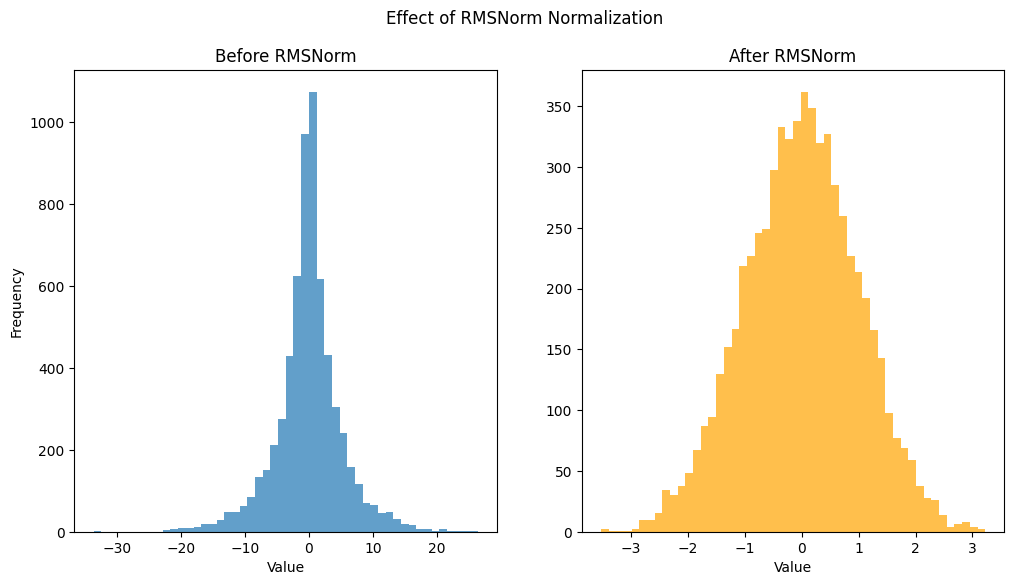

In [43]:
import matplotlib.pyplot as plt

#generate fake data
dim = 128  # Feature dimension
batch_size = 5  # Number of sequences in a batch
seq_len = 10  # Number of tokens per sequence
eps = 1e-6  # Small epsilon for numerical stability

#fake input data resembling embeddings or features in a model like LLaMA 2
x = torch.randn(batch_size, seq_len, dim) * torch.randint(1, 10, (batch_size, seq_len, 1)).float()

#initialize RMSNorm
rms_norm = RMSNorm(dim, eps)

#apply RMSNorm to the fake data
normalized_x = rms_norm(x)

#plotting function to visualize the effect of RMSNorm
def plot_data(before, after, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(before.flatten().numpy(), bins=50, alpha=0.7)
    plt.title('Before RMSNorm')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(after.flatten().detach().numpy(), bins=50, alpha=0.7, color='orange')  # Updated to use .detach().numpy()
    plt.title('After RMSNorm')
    plt.xlabel('Value')

    plt.suptitle(title)
    plt.show()

# Visualize the effect of RMSNorm again with the updated plotting function
plot_data(x, normalized_x, 'Effect of RMSNorm Normalization')

# Swi-GLU Activation

The paper proposed additional variants of the Transformer FFN layer from "Attention Is All You Need":

FFNGLU(x,W,V,W2) = (σ(xW)⊗xV)W2

FFNBilinear(x,W,V,W2) = (xW ⊗xV )W2

FFNReGLU(x,W,V,W2) = (max(0,xW)⊗xV)W2

FFNGEGLU(x,W,V,W2) = (GELU(xW)⊗xV)W2

FFNSwiGLU(x,W,V,W2) = (Swish1(xW)⊗xV)W2

From the conclusion of https://arxiv.org/pdf/2002.05202.pdf 

"In a transfer-learning setup the new variants seem to produce better perplexities for the de-noising objective used in pre-training, as well as better results on many downstream language-understanding tasks.These architectures are simple to implement, and have no apparent computational drawbacks. We offer no explanation as to why these architectures seem to work; we attribute their success, as all else, to divine benevolence. 

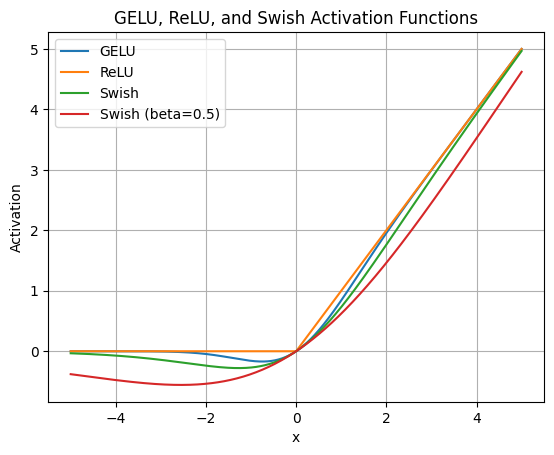

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def gelu(x):
   return x * norm.cdf(x)

def relu(x):
   return np.maximum(0, x)

def swish(x, beta=1):
   return x * (1 / (1 + np.exp(-beta * x)))

# Wasnt able to find this value listed in the paper, I believe it is learned. 
beta = .5

x_values = np.linspace(-5, 5, 500)
gelu_values = gelu(x_values)
relu_values = relu(x_values)
swish_values = swish(x_values)
swish_values2 = swish(x_values, beta=beta)

plt.plot(x_values, gelu_values, label='GELU')
plt.plot(x_values, relu_values, label='ReLU')
plt.plot(x_values, swish_values, label='Swish')
plt.plot(x_values, swish_values2, label=f'Swish (beta={beta})')
plt.title("GELU, ReLU, and Swish Activation Functions")
plt.xlabel("x")
plt.ylabel("Activation")
plt.grid()
plt.legend()
plt.show()

In [45]:
class SwiGLU(nn.Module):
    """
    SwiGLU paper:
    https://arxiv.org/pdf/2002.05202v1.pdf

    Swish activation function with Gated Linear Unit (GLU) gating mechanism
    """
    def __init__(self, size: int, config: ModelConfig):
        super().__init__()
        self.config = config
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True) # Learned parameter

        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x): 
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out

In [46]:
class SelfAttention(nn.Module):

    def __init__(self, args: ModelConfig):
        super().__init__()
        self.dim = args.dim

        # Determine the number of key-value heads (defaults to n_heads if not specified)
        self.n_kv_heads = args.n_kv_heads if args.n_kv_heads is not None else args.n_heads

        # Set the number of query heads and the number of repetitions for K and V
        self.n_heads_q = args.n_heads
        self.n_rep = self.n_heads_q // self.n_kv_heads

        # Calculate the head dimension
        self.head_dim = args.dim // args.n_heads

        # Linear transformations for queries, keys, values, and output
        self.Wq = nn.Linear(args.dim, args.n_heads * self.head_dim, bias=False)
        self.Wk = nn.Linear(args.dim, args.n_kv_heads * self.head_dim, bias=False)
        self.Wv = nn.Linear(args.dim, args.n_kv_heads * self.head_dim, bias=False)
        self.Wo = nn.Linear(args.n_heads * self.head_dim, args.dim, bias=False)

        # Initialize key and value caches with zeros
        self.cache_k = torch.zeros((args.max_batch_size, args.max_seq_len, args.n_kv_heads, self.head_dim))
        self.cache_v = torch.zeros((args.max_batch_size, args.max_seq_len, args.n_kv_heads, self.head_dim))

        # Rotary Position Embedding
        self.rope = RotaryPositionEmbedding(self.head_dim, args.max_seq_len, args.device)

    @staticmethod
    def repeat_heads(x: torch.Tensor, n_rep: int) -> torch.Tensor:

        # Repeat the heads of K and V to match the number of heads in Q

        batch_size, seq_len, n_kv_heads, head_dim = x.shape
        if n_rep == 1:
            return x
        else:
            return (x[:, :, :, None, :]
                    .expand(batch_size, seq_len, n_kv_heads, n_rep, head_dim)
                    .reshape(batch_size, seq_len, n_kv_heads * n_rep, head_dim)
                    )

    def forward(self, x: torch.Tensor, start_pos: int) -> torch.Tensor:
        batch_size, seq_len, dim = x.shape  # (B, 1, dim)
        assert dim == self.dim, "dim must be equal to self.dim"

        # (B, 1, dim) -> (B, 1, n_heads_q * head_dim)
        xq = self.Wq(x)

        # (B, 1, dim) -> (B, 1, n_kv_heads * head_dim)
        xk = self.Wk(x)

        # (B, 1, dim) -> (B, 1, n_kv_heads * head_dim)
        xv = self.Wv(x)

        # (B, 1, n_heads_q * head_dim) -> (B, 1, n_heads_q, head_dim)
        xq = xq.view(batch_size, seq_len, self.n_heads_q, self.head_dim)

        # (B, 1, n_kv_heads * head_dim) -> (B, 1, n_kv_heads, head_dim)
        xk = xk.view(batch_size, seq_len, self.n_kv_heads, self.head_dim)
        xv = xv.view(batch_size, seq_len, self.n_kv_heads, self.head_dim)

        xq = self.rope(xq, start_pos)
        xk = self.rope(xk, start_pos)

        # Update key and value caches
        self.cache_k[:batch_size, start_pos:start_pos + seq_len] = xk
        self.cache_v[:batch_size, start_pos:start_pos + seq_len] = xv

        # Retrieve key and value caches
        keys = self.cache_k[:batch_size, :start_pos + seq_len]
        values = self.cache_v[:batch_size, :start_pos + seq_len]

        # Repeat the heads of K and V to match the number of heads in Q
        keys = self.repeat_heads(keys, self.n_rep)
        values = self.repeat_heads(values, self.n_rep)

        # (B, 1, n_heads_q, head_dim) -> (B, n_heads_q, 1, head_dim)
        xq = xq.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        # (B, n_heads_q, 1, head_dim) * (B, n_heads_q, head_dim, SeqLen) -> (B, n_heads_q, 1, SeqLen)
        scores = torch.matmul(xq, keys.transpose(-2, -1)) / math.sqrt(self.head_dim)
        scores = F.softmax(scores.float(), dim=-1).type_as(xq)

        # (B, n_heads_q, 1, SeqLen) * (B, n_heads_q, SeqLen, head_dim) -> (B, n_heads_q, 1, head_dim)
        context = torch.matmul(scores, values)

        # (B, n_heads_q, 1, head_dim) -> (B, 1, head_dim)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)

        # (B, 1, head_dim) -> (B, 1, dim)
        output = self.Wo(context)

        return output


class FeedForward(nn.Module):

    def __init__(self, args: ModelConfig):
        super().__init__()

        # Calculate the hidden dimension based on the provided parameters
        hidden_dim = 4 * args.dim
        hidden_dim = int(2 * hidden_dim / 3)

        # Adjust the hidden dimension based on ffn_dim_multiplier (if provided)
        if args.ffn_dim_multiplier is not None:
            hidden_dim = int(args.ffn_dim_multiplier * hidden_dim)

        # Ensure hidden_dim is a multiple of args.multiple_of
        if hasattr(args, 'multiple_of'):
            hidden_dim = args.multiple_of * ((hidden_dim + args.multiple_of - 1) // args.multiple_of)

        # Use ffn_dim_multiplier to calculate the hidden dimension if it exists
        if hasattr(args, 'ffn_dim_multiplier') and args.ffn_dim_multiplier is not None:
            hidden_dim = int(args.ffn_dim_multiplier * hidden_dim)
        
        # Initialize SwiGLU layers
        self.swiglu1 = SwiGLU(args.dim, args)
        self.swiglu2 = SwiGLU(hidden_dim, args)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input shape: (Batch_Size, SeqLen, Dim)

        # Apply the first linear transformation and activation (swish)
        x = self.swiglu1(x)

        # Apply the second linear transformation and activation (swish)
        x = self.swiglu2(x)

        return x  # Return the output tensor


class EncoderBlock(nn.Module):

    def __init__(self, args: ModelConfig):
        super().__init__()

        self.n_heads = args.n_heads
        self.dim = args.dim
        self.head_dim = args.dim // args.n_heads

        self.attention = SelfAttention(args)
        self.feed_forward = FeedForward(args)

        self.norm1 = RMSNorm(args.dim, args.norm_eps)
        self.ffn_norm = RMSNorm(args.dim, args.norm_eps)

    def forward(self, x: torch.Tensor, start_pos: int) -> torch.Tensor:
        h = x + self.attention(self.norm1(x), start_pos)
        out = h + self.feed_forward(self.ffn_norm(h))
        return out


class Transformer(nn.Module):

    def __init__(self, args: ModelConfig) -> None:
        super().__init__()

        # Check if vocab_size is specified
        assert args.vocab_size != -1, "vocab_size must be specified"

        # Store model configuration and necessary parameters
        self.args = args
        self.vocab_size = args.vocab_size
        self.n_layers = args.n_layers

        # Embedding layer for token embeddings
        self.embeddings = nn.Embedding(self.vocab_size, args.dim)

        # Create a list of transformer encoder blocks
        self.layers = nn.ModuleList()
        for _ in range(args.n_layers):
            self.layers.append(EncoderBlock(args))

        # Layer normalization for the output
        self.norm = RMSNorm(args.dim, args.norm_eps)

        # Output linear layer
        self.output = nn.Linear(args.dim, self.vocab_size, bias=False)

    def forward(self, x: torch.Tensor, start_pos: int) -> torch.Tensor:
        # Input shape: (Batch_Size, SeqLen)

        # Ensure seq_len is 1
        assert x.shape[1] == 1, "seq_len must be 1"

        # Embedding lookup
        x = self.embeddings(x)

        # Pass through each transformer encoder block
        for layer in self.layers:
            x = layer(x, start_pos)

        # Layer normalization
        x = self.norm(x)

        # Output prediction
        x = self.output(x)

        return x  # Return the output

Resources: 

https://huggingface.co/blog/llama2

https://medium.com/@jain.sm/understanding-llama-2-333aae52508c

https://github.com/bkitano/llama-from-scratch/tree/main

https://arxiv.org/pdf/2002.05202.pdf

https://arxiv.org/pdf/2307.09288.pdf

https://github.com/meta-llama/llama/blob/main/llama/model.py 
